In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split





In [3]:
# Load the dataset
file_path = 'META.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime and sort by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Use 'Adj Close' for prediction
prices = data[['Adj Close']].values



In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [5]:
# Create sequences for LSTM input
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)



In [6]:
time_step = 60
X, y = create_sequences(prices_scaled, time_step)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



In [9]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))




Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0499 - val_loss: 5.1673e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4415e-04 - val_loss: 4.6965e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.9431e-04 - val_loss: 4.4087e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.8913e-04 - val_loss: 4.1755e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.0969e-04 - val_loss: 4.8357e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7666e-04 - val_loss: 4.3479e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3469e-04 - val_loss: 3.7392e-04
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5467e-04 - val_loss: 4.8104e-04
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4359e-04 - val_loss: 4.5968e-04
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.9709e-04 - val_loss: 3.3432e-04
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0945e-04 - 

In [10]:
# Predict on the test data
predicted_prices = model.predict(X_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [11]:
# Inverse scale predictions and actual prices
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))



In [13]:
# Evaluate and print metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 3.768200496052417
Mean Squared Error (MSE): 31.731231224067603
Root Mean Squared Error (RMSE): 5.633048129038807


In [14]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(actual_prices, predicted_prices)

# Print R-squared along with other metrics
print(f"R-squared (R²): {r2}")

R-squared (R²): 0.9959836082357559


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert prices to binary labels (1: increase, 0: decrease)
actual_labels = (np.diff(actual_prices.flatten(), prepend=actual_prices[0]) > 0).astype(int)
predicted_labels = (np.diff(predicted_prices.flatten(), prepend=predicted_prices[0]) > 0).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, zero_division=1)
recall = recall_score(actual_labels, predicted_labels, zero_division=1)
f1 = f1_score(actual_labels, predicted_labels, zero_division=1)

# Print classification metrics
print("Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Classification Metrics:
Accuracy: 0.980701754385965
Precision: 0.9819494584837545
Recall: 0.9784172661870504
F1 Score: 0.9801801801801802


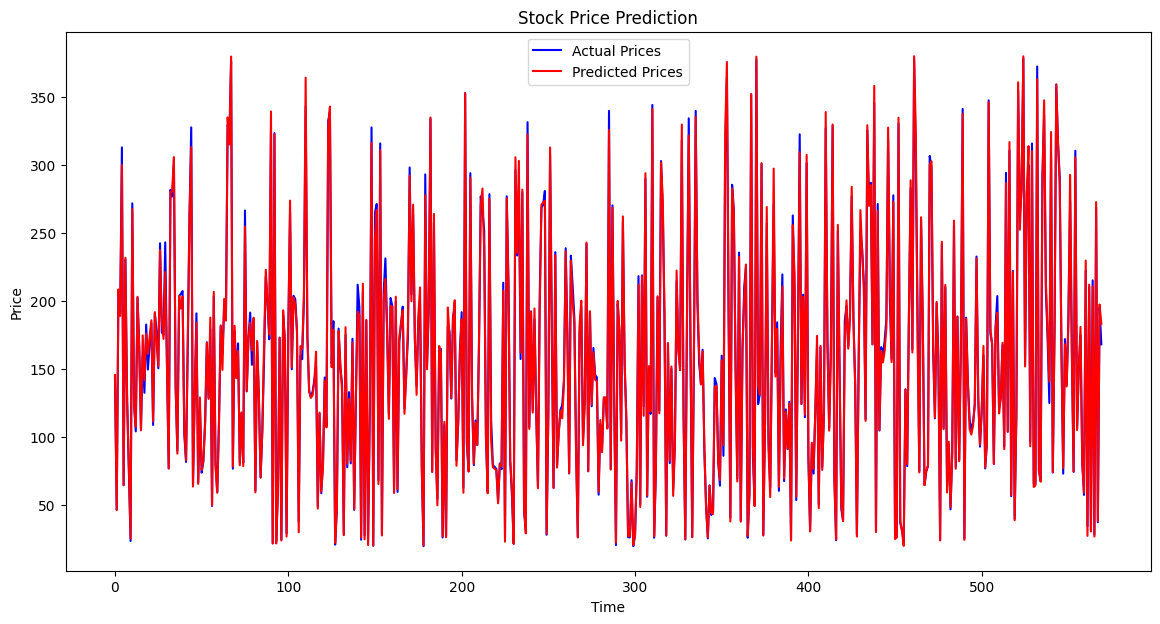

In [12]:
# Evaluate and visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
